In [12]:
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

feature_matching = 'flann' # For which Matcher to use

# Getting Key-Points and Descriptors  for the images

We use **SIFT** algorithm

In [2]:
def detectAndDescribe(image):
    extractor = cv2.SIFT_create()
    # get keypoints and descriptors
    (kps, features) = extractor.detectAndCompute(image, None)
    
    return (kps, features)

In [3]:
def matchKeyPoins_BF(featuresA,featuresB):
    good_matches = []
    matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    # matches = matcher.knnMatch(featuresA, featuresB, k=2)
    matches = matcher.match(featuresA, featuresB)
    matches = sorted(matches, key = lambda x:x.distance)
    
    return matches

def matchKeyPoins_FLANN(featuresA,featuresB):
    good_matches = []
    # Using FLANN-based Matcher to match the descriptors
    # FLANN parameters.
    index_params = dict(algorithm=0, trees=5)
    search_params = dict(checks=50)
    # FLANN based matcher with implementation of k nearest neibhour.
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    matches = matcher.knnMatch(featuresA, featuresB, k=2)
    print("Raw matches: ", len(matches))

    # Filter matches using Lowe's ratio test
    ratio_thresh = 0.75
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    return good_matches

def matchKeyPoints_KNN(featuresA, featuresB, ratio = 0.75):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

# Performing Homography
This will return a 3x3 matrix that maps the point in one image to the point in other image 

In [4]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

# Reading the Images

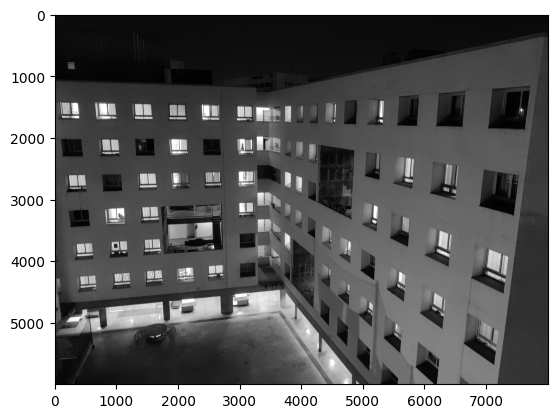

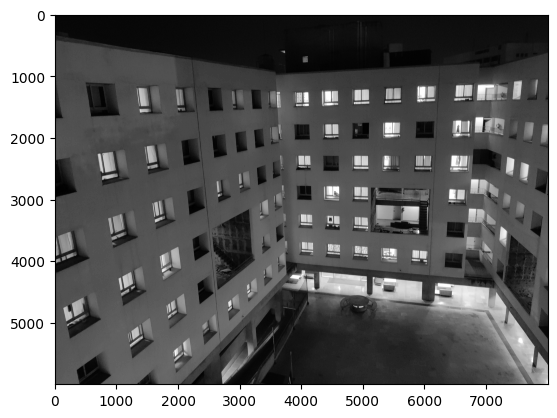

In [5]:
train_img = cv2.imread('1.jpg')
train_img_gray = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)

test_img = cv2.imread('2.jpg')
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

cmap = 'gray'

plt.figure()
plt.imshow(train_img_gray, cmap = cmap)
plt.show()

plt.imshow(test_img_gray, cmap = cmap)
plt.show()

# Extracting the keypoints and features/descriptors

In [6]:
kpsA, featuresA = detectAndDescribe(train_img_gray)
kpsB, featuresB = detectAndDescribe(test_img_gray)


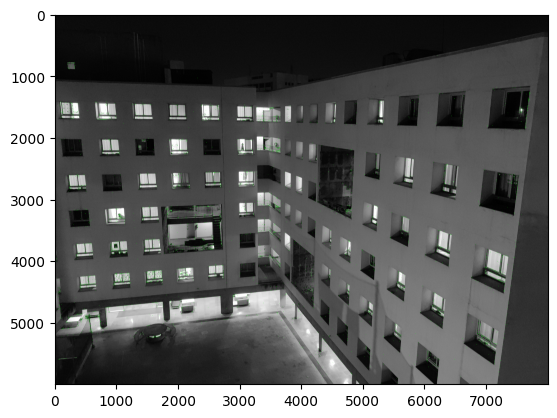

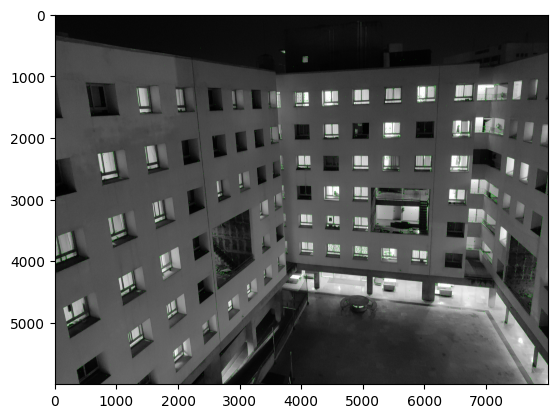

In [7]:
key1 = cv2.drawKeypoints(train_img_gray, kpsA, None, color=(0, 255, 0))
key2 = cv2.drawKeypoints(test_img_gray, kpsB, None, color=(0, 255, 0))

plt.figure()
plt.imshow(key1)
plt.show()

plt.imshow(key2)
plt.show()

Using: flann feature matcher
Raw matches:  6980


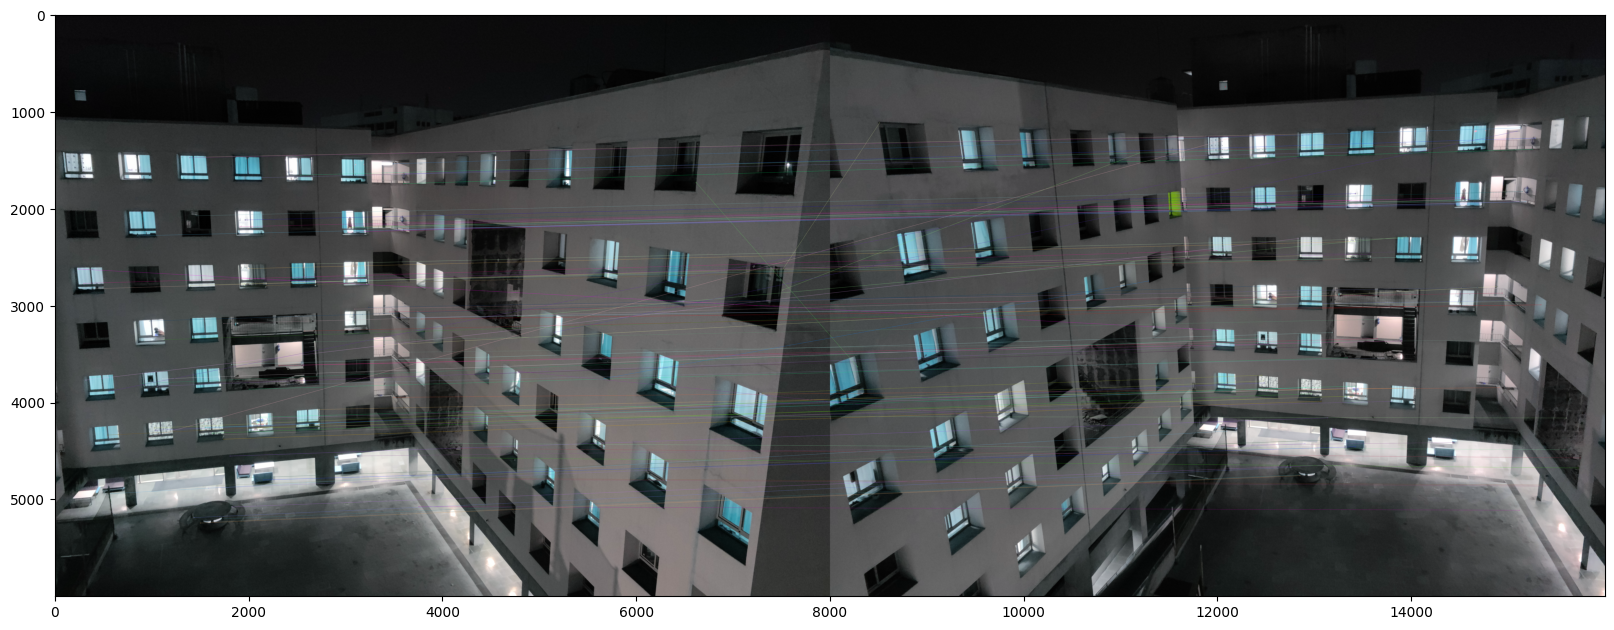

In [8]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPoins_BF(featuresA, featuresB)
    img3 = cv2.drawMatches(train_img,kpsA,test_img,kpsB,matches[:100],
# feature_extractor = 'sift'
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPoints_KNN(featuresA, featuresB, ratio=0.75)
    img3 = cv2.drawMatches(train_img,kpsA,test_img,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'flann':
    matches = matchKeyPoins_FLANN(featuresA, featuresB)
    img3 = cv2.drawMatches(train_img,kpsA,test_img,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    

plt.imshow(img3)
plt.show()

In [9]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=5)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 4.50218580e-01 -1.80062061e-02  3.90745872e+03]
 [-1.37042145e-01  8.73144647e-01  4.36083036e+01]
 [-7.03685845e-05  7.36921106e-06  1.00000000e+00]]


# Perspective Transformtion

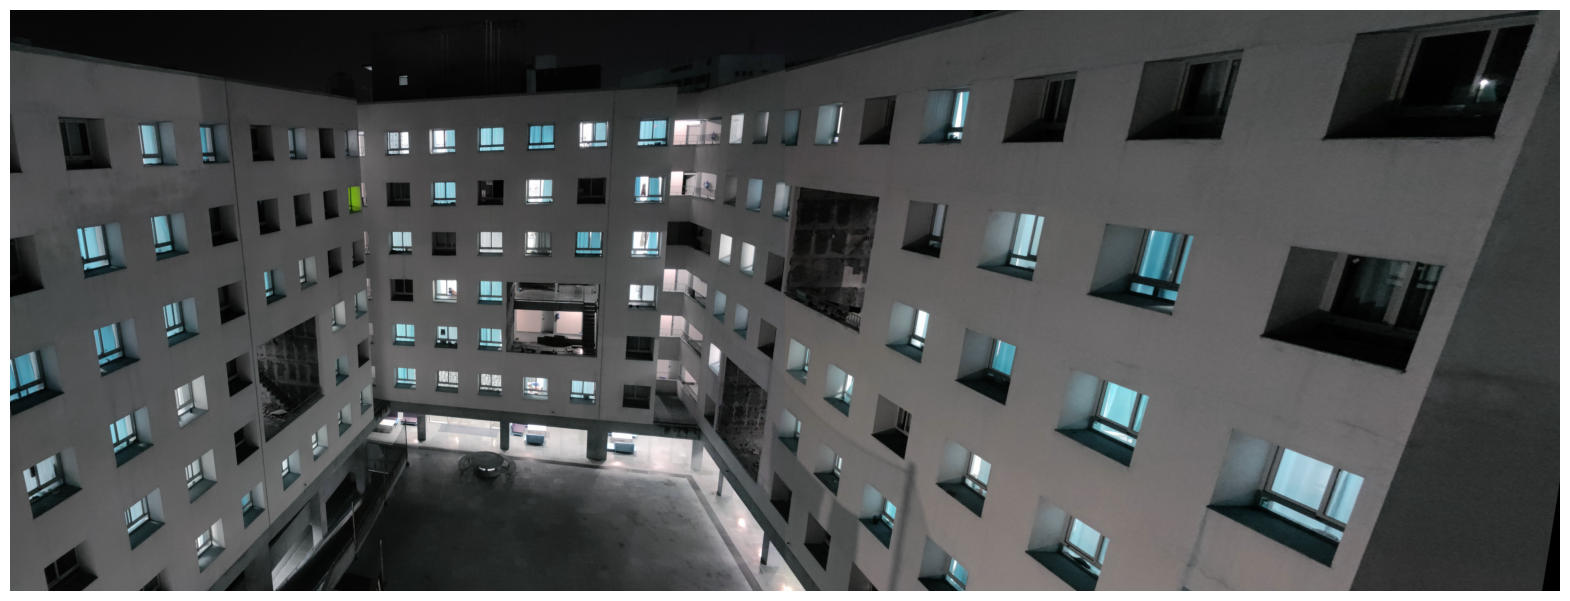

True

In [10]:
# Apply panorama correction
width = train_img.shape[1] + test_img.shape[1]
height = test_img.shape[0]
result = cv2.warpPerspective(train_img, H, (width, height))
result[0:test_img.shape[0], 0:test_img.shape[1]] = test_img

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

cv2.imwrite('Panaroma1.jpg', result)

Removing the black patch(if any are present)

True

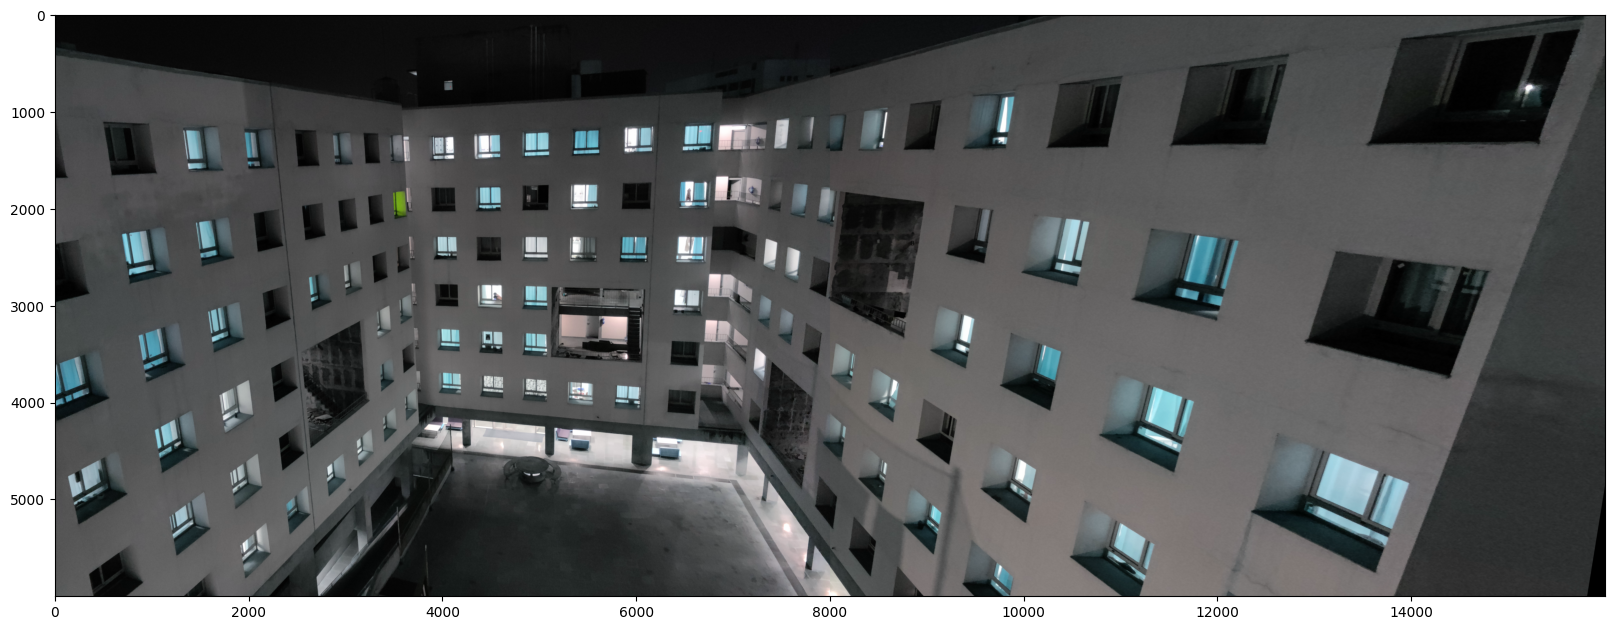

In [11]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
Threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
contours = cv2.findContours(Threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

# get the maximum contour area
max_ContourArea = max(contours, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, width, height) = cv2.boundingRect(max_ContourArea)

# crop the image to the bbox coordinates
result = result[y:y + height, x:x + width]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

cv2.imwrite('Panaroma1.jpg', result)